In [1]:
import pandas as pd
import joblib
import numpy as np
import pandas as pd
import torch
import os
import torch.optim as optim
import warnings 
warnings.simplefilter('ignore')
from torch.nn import Linear,ReLU,Sigmoid
from utils import *
torch.cuda.is_available()

True

In [2]:
os.listdir('./data')

['train_preprocessed',
 'PA_201605-2020001更新R8(20200423).csv',
 'tag盤點表20200423.xlsx',
 'pred_0997_all.csv',
 'train_cleaned.csv',
 'tag_cleaned.csv']

# load data,tag,critic,mm_x,mm_y

In [3]:
data = joblib.load('./data/train_preprocessed')

In [4]:
tag = pd.read_csv('./data/tag_cleaned.csv')
tag_map = dict(zip(tag['TAG'],tag['chinese']))

In [5]:
critic = joblib.load('./model/net.pkl')
critic = critic.eval()
mm_x = joblib.load('./model/mm_x.pkl')
mm_y = joblib.load('./model/mm_y.pkl')

# def columns

In [6]:
x_cols = data['x_col']
y_cols = data['y_col']

In [7]:
x_cols

['MLPAP_FQ-0619.PV',
 'MLPAP_FR-0632.PV',
 'MLPAP_LIC-0738.PV',
 'MLPAP_LRC-0729.PV',
 'MLPAP_PIC-0761.PV',
 'MLPAP_TJ-0757B.PV',
 'MLPAP_TJC-0627.PV',
 'MLPAP_TJC-0757A.PV',
 'MLPAP_TJC-1721.PV',
 'MLPAP_TRC-0610.PV',
 'MLPAP_TRC-0747.PV',
 'MLPAP_TRC-0762.PV',
 'MLPAP_TRC-1734.PV']

In [8]:
y_cols

['MLPAP_FQI-0997.PV']

# critic forward test

In [9]:
t = critic.time_step
n = critic.num_sensor
t,n

(39, 13)

In [10]:
x = np.random.uniform(0,1,size=(t,n))
x = pd.DataFrame(x,columns=x_cols)
x.head()

,MLPAP_FQ-0619.PV,MLPAP_FR-0632.PV,MLPAP_LIC-0738.PV,MLPAP_LRC-0729.PV,MLPAP_PIC-0761.PV,MLPAP_TJ-0757B.PV,MLPAP_TJC-0627.PV,MLPAP_TJC-0757A.PV,MLPAP_TJC-1721.PV,MLPAP_TRC-0610.PV,MLPAP_TRC-0747.PV,MLPAP_TRC-0762.PV,MLPAP_TRC-1734.PV
0,0.764491,0.793647,0.493109,0.402323,0.121288,0.220604,0.845217,0.341748,0.828474,0.104861,0.854533,0.836063,0.077833
1,0.449790,0.207589,0.617783,0.979570,0.249947,0.698360,0.760960,0.551403,0.612575,0.752106,0.748944,0.044459,0.401593
2,0.743973,0.234615,0.737070,0.981238,0.043582,0.611680,0.489980,0.776774,0.744538,0.360018,0.749893,0.935489,0.210700
3,0.043282,0.464800,0.680941,0.566165,0.258945,0.406038,0.644817,0.078222,0.584410,0.370124,0.172916,0.839875,0.400485
4,0.618680,0.412412,0.900306,0.970726,0.315137,0.081503,0.182594,0.966963,0.089190,0.550365,0.494926,0.072660,0.212647


In [11]:
y = critic(torch.tensor(x.values.reshape(-1,t*n)).cuda())
print(y)
y = mm_y.inverse_transform(y.detach().cpu().numpy())
y

tensor([[0.5076]], device='cuda:0', dtype=torch.float64,
       grad_fn=<SigmoidBackward>)


array([[7540.6914638]])

# build Actor input set_point output feed and control_factor

In [12]:
def build_Actor(input_shape,output_shape):
    net = torch.nn.Sequential(
        Linear(input_shape,256),
        ReLU(),
        Linear(256,output_shape),
        Sigmoid()
    )
    return net

In [13]:
def init_weights(m):
  if hasattr(m,'weight'):
    torch.nn.init.xavier_uniform(m.weight)
  if hasattr(m,'bias'):  
    m.bias.data.fill_(0)

In [14]:
net = build_Actor(1,t*n).double().cuda()
net.apply(init_weights)
net

Sequential(
  (0): Linear(in_features=1, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=507, bias=True)
  (3): Sigmoid()
)

# st_iter

In [15]:
st = torch.tensor(np.random.uniform(0,1,size=(5000,1))).cuda()
st_datasets = torch.utils.data.TensorDataset(st)
st_iter = torch.utils.data.DataLoader(st_datasets,batch_size=128)
st_iter

# obj function

In [16]:
def obj_function(x,set_point):
    y = critic(x)
    loss = (set_point - y)**2
    return loss.mean()

# optimizer

In [17]:
optimizer = optim.Adam(net.parameters(),lr=1e-4)

# train

In [18]:
def train(net,st_iter,obj_function,optimizer,num_epochs=100):
    train_history = []
    for epoch in range(num_epochs):
        train_avg_loss = 0
        t = 0
        for st in st_iter:
            st = st[0]
            z = net(st).cuda()
            loss = obj_function(z,st)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_avg_loss += loss.item()
            t += 1
        train_avg_loss /= t
        print("epochs {} loss {:.4f}".format(epoch,train_avg_loss))
        train_history.append(train_avg_loss)
    # plt train loss
    plt.plot(np.array(train_history))
    plt.title('train loss')
    # return trained net
    return net

epochs 0 loss 0.0764
epochs 1 loss 0.0567
epochs 2 loss 0.0473
epochs 3 loss 0.0400
epochs 4 loss 0.0344
epochs 5 loss 0.0297
epochs 6 loss 0.0258
epochs 7 loss 0.0225
epochs 8 loss 0.0197
epochs 9 loss 0.0172
epochs 10 loss 0.0152
epochs 11 loss 0.0135
epochs 12 loss 0.0121
epochs 13 loss 0.0110
epochs 14 loss 0.0100
epochs 15 loss 0.0092
epochs 16 loss 0.0085
epochs 17 loss 0.0079
epochs 18 loss 0.0074
epochs 19 loss 0.0069
epochs 20 loss 0.0065
epochs 21 loss 0.0061
epochs 22 loss 0.0058
epochs 23 loss 0.0055
epochs 24 loss 0.0052
epochs 25 loss 0.0050
epochs 26 loss 0.0048
epochs 27 loss 0.0045
epochs 28 loss 0.0043
epochs 29 loss 0.0042
epochs 30 loss 0.0040
epochs 31 loss 0.0039
epochs 32 loss 0.0038
epochs 33 loss 0.0037
epochs 34 loss 0.0036
epochs 35 loss 0.0035
epochs 36 loss 0.0034
epochs 37 loss 0.0033
epochs 38 loss 0.0032
epochs 39 loss 0.0032
epochs 40 loss 0.0031
epochs 41 loss 0.0031
epochs 42 loss 0.0030
epochs 43 loss 0.0029
epochs 44 loss 0.0029
epochs 45 loss 0.002

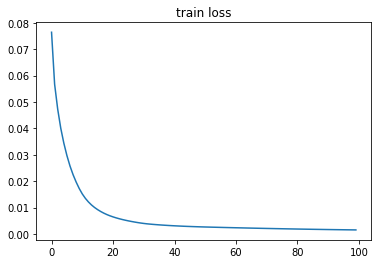

In [19]:
net = train(net,st_iter,obj_function,optimizer,num_epochs=100)

# result

In [20]:
set_point = mm_y.inverse_transform(st.detach().cpu().numpy())
critic_output = mm_y.inverse_transform(critic(net(st)).detach().cpu().numpy())

In [21]:
for i,j in zip(set_point[:10],critic_output[:10]):
    print('user_want:{} critic_output{}'.format(i,j))

user_want:[9298.47894371] critic_output[9283.66674413]
user_want:[8190.36430589] critic_output[8286.60260731]
user_want:[6252.60632995] critic_output[6191.54909943]
user_want:[7401.44545944] critic_output[7387.33835278]
user_want:[8576.3829697] critic_output[8690.8518816]
user_want:[5618.36438416] critic_output[5815.71660951]
user_want:[8507.91238595] critic_output[8621.33991322]
user_want:[8694.35240213] critic_output[8806.24238317]
user_want:[9997.53818224] critic_output[9623.48673483]
user_want:[7213.57247758] critic_output[7168.34416866]


# build api

In [22]:
def get_advice(set_point):
    st = mm_y.transform(np.array([[set_point]]))
    st = torch.tensor(st).cuda()
    z = net(st)
    return z

In [23]:
def get_critic_output(advice):
    return mm_y.inverse_transform(critic(advice).detach().cpu().numpy())

# test api

In [24]:
advice = get_advice(8000)
get_critic_output(advice)

array([[8079.31917769]])